In [61]:
import json
import string
import pandas as pd
import re
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from langdetect import detect, DetectorFactory
from difflib import get_close_matches as gcm

In [2]:
skills = pd.read_csv('skills_db/skill.csv')
skills.head()

,skill_id,skill
0,126,Applied Science
1,139,Art
2,279,Business
3,459,Computer Science
4,589,Data Science


In [3]:
sk_list = skills['skill'].tolist()
len(sk_list)

2605

In [4]:
with open('resource/job_infos_scrape.json') as f:
    jobs = json.load(f)

len(jobs)

19680

In [5]:
jobs['0']

{'title': 'SALES ASSOCIATE',
 'job_details': '* Under supervision and perform duties to provide technical product assistance/knowledge to customers in order to generate new and repeat sales.\n* Assist customers in the selection of the best products that suited to their needs and desires and explain use, operation, care of the merchandise products and services to customers.\n* Explain the terms of sales, availability of the product and delivery dates and related information and process orders to customers.\n* Handle customers inquiries and complaint.\n* Keep display items clean and displayable and overall cleanliness of the branch.\n* To  handle  any  other  job  as  may be  assigned  by  the  superior.\n\nLocation : Tropicana Aman, Denai Alam, Wisma WCC, Puchong, Bandar Botanik, Sri Petaling, Pandan Indah, Rawang, Sungai Buloh, Kota Damansara, Kajang, Bangi , Balakong, USJ Taipan, Kota Kemuning, Shah Alam.',
 'requirement': 'Permanent| 3 Shift Time |STPM / A Level or Equivalent|Today',

In [6]:
rs = []
i = 0

for j in jobs:
    rs.append(jobs[j]['requirement'].split('|')[2])

set(rs)

{"Bachelor's or Equivalent",
 'Diploma / Advanced Diploma / Higher Graduate Diploma / DVM / DKM Level 4 / DLKM Level 5',
 'Diploma / Advanced Diploma / Higher Graduate Diploma / DVM /…',
 'Diploma / Advanced Diploma / Higher Graduate…',
 'Doctoral (PhD) or Equivalent',
 "Master's or Equivalent",
 'PMR / PT3 or Equivalent',
 'Primary Education or Below',
 'SPM / O Level / SKM Level 1 / SKM Level 2 / SKM Level 3 or Equivalent',
 'SPM / O Level / SKM Level 1 / SKM Level 2 / SKM Level 3 or…',
 'STPM / A Level or Equivalent'}

In [31]:
def extract_skills(info):
    words = info.translate(str.maketrans('', '', string.punctuation))
    words = ' '.join(words.split('\n')).split()
    results = []
    for s in sk_list:
        if '(' in s:
            abb = s[s.find("(")+1:s.find(")")]
            result = gcm(abb, words, n=len(words), cutoff=0.9)
            if len(result) > 0:
                results.append(s)
                continue
        result = gcm(s, words, n=len(words), cutoff=0.8)
        if len(result) > 0:
            results.append(s)
    return results

In [54]:
x = dt.now()
x

datetime.datetime(2021, 1, 11, 11, 10, 7, 914490)

In [55]:
y = dt.now() - x
print("{}".format(y))

0:00:15.954937


In [56]:
i = 0
job_info_list = []
DetectorFactory.seed = 42
initial = dt.now()
interval = dt.now()
print_every = 500

for j in jobs:
    i += 1
    if i % print_every == 0:
        print("{} jobs processed. Time taken: {}".format(i, dt.now() - interval))
        interval = dt.now()
    job = jobs[j]
    all_info = job['title'] + ' ' + job['job_details']
    job_type = job['requirement'].split('|')[0]
    education = job['requirement'].split('|')[2]
    if len(job['job_details']) < 3:
        language = None
    else:
        language = detect(job['job_details'])
    skills = extract_skills(all_info)
    job_info_list.append({
        'job_title': job['title'],
        'job_details': job['job_details'],
        'job_type': job_type,
        'education_requirement': education,
        'language': language,
        'skills_required': skills,
        'no_skills_required': len(skills)})

print("Total time taken: {}".format(dt.now() - initial))

500 jobs processed. Time taken: 0:02:35.162769
1000 jobs processed. Time taken: 0:02:28.516506
1500 jobs processed. Time taken: 0:02:39.694426
2000 jobs processed. Time taken: 0:02:28.488194
2500 jobs processed. Time taken: 0:02:57.859004
3000 jobs processed. Time taken: 0:01:30.184948
3500 jobs processed. Time taken: 0:02:36.266365
4000 jobs processed. Time taken: 0:02:53.165805
4500 jobs processed. Time taken: 0:02:34.100019
5000 jobs processed. Time taken: 0:02:32.746931
5500 jobs processed. Time taken: 0:02:22.915019
6000 jobs processed. Time taken: 0:02:18.123717
6500 jobs processed. Time taken: 0:02:48.694209
7000 jobs processed. Time taken: 0:02:26.514651
7500 jobs processed. Time taken: 0:02:42.409217
8000 jobs processed. Time taken: 0:02:36.607376
8500 jobs processed. Time taken: 0:03:06.027526
9000 jobs processed. Time taken: 0:02:36.311976
9500 jobs processed. Time taken: 0:02:15.242623
10000 jobs processed. Time taken: 0:02:15.539480
10500 jobs processed. Time taken: 0:02:4

## Analysis

In [57]:
df = pd.DataFrame.from_dict(job_info_list)
df.head()

,job_title,job_details,job_type,education_requirement,language,skills_required,no_skills_required
0,SALES ASSOCIATE,* Under supervision and perform duties to prov...,Permanent,STPM / A Level or Equivalent,en,"[Sales, Operations, Operation, Process, Servic...",8
1,SIGN HOUSE ADVERTISING,Kelebihan diberi kepada yang mempunyai kemahir...,Permanent,Bachelor's or Equivalent,id,[Adobe],1
2,MR DIY (M) SDN BHD,"Receive stock, checking & distribution item re...",Permanent,Diploma / Advanced Diploma / Higher Graduate…,en,"[Operations, Operation, Bagging, Distribution,...",5
3,Petugas PDK,"1. Bertanggungjawab kepada penyelia PDK, jawat...",Permanent,Bachelor's or Equivalent,id,[Creativity],1
4,MR DIY (M) SDN BHD,"Receive stock, checking & distribution item re...",Permanent,SPM / O Level / SKM Level 1 / SKM Level 2 / SK...,en,"[Operations, Operation, Bagging, Distribution,...",5


In [59]:
df.to_csv('resource/myfuturejobs_skills.csv', index=False)

In [58]:
df.describe(include='all')

,job_title,job_details,job_type,education_requirement,language,skills_required,no_skills_required
count,19680,19680,19680,19680,19670,19680,19680.000000
unique,4856,3296,6,11,26,3065,NaN
top,General Worker,Sales assistants represent the direct contact ...,Permanent,SPM / O Level / SKM Level 1 / SKM Level 2 / SK...,en,[],NaN
freq,128,167,15653,7988,16950,3521,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.455234
std,NaN,NaN,NaN,NaN,NaN,NaN,8.495129
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000


In [60]:
df['job_type'].describe()

count         19680
unique            6
top       Permanent
freq          15653
Name: job_type, dtype: object

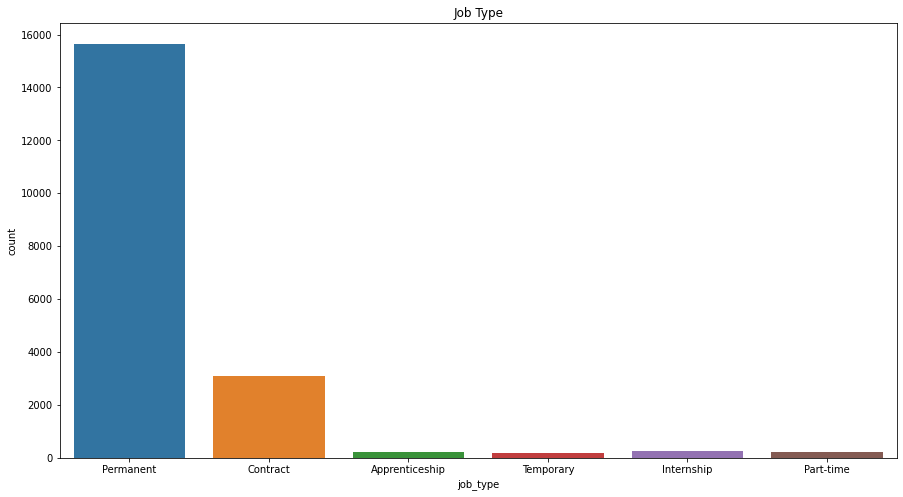

In [64]:
plt.figure(figsize=(15,8))
sns.countplot(x='job_type', data=df).set_title('Job Type');

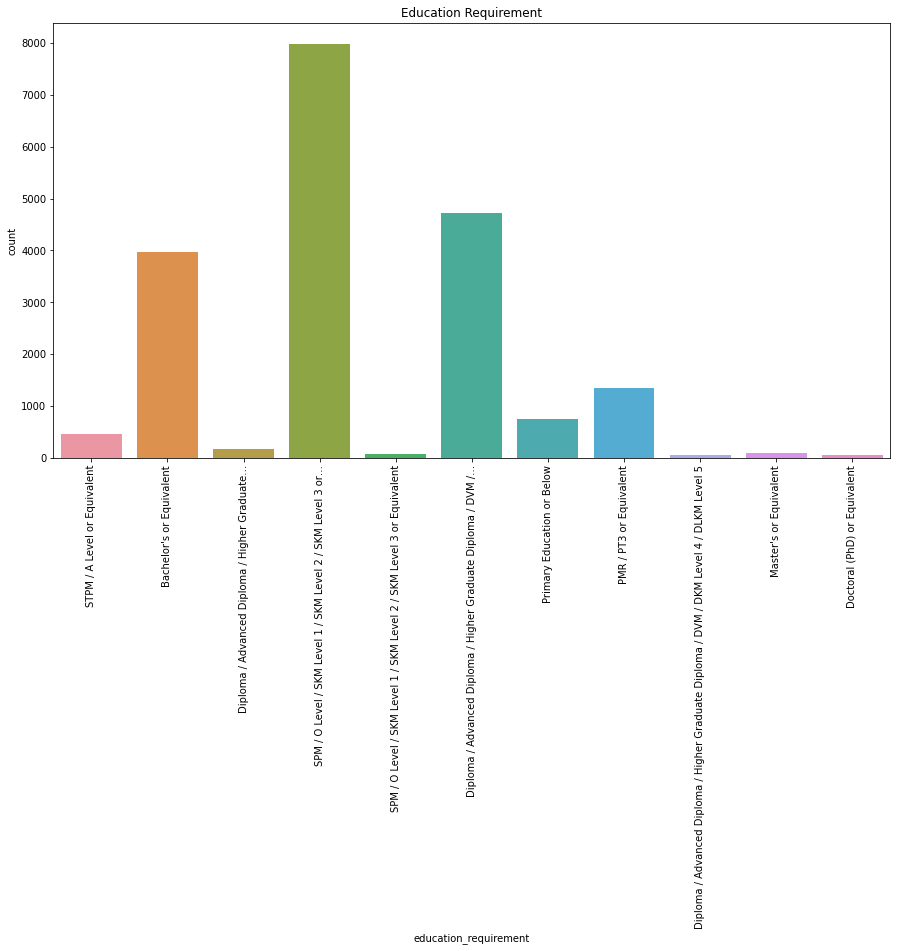

In [69]:
plt.figure(figsize=(15,8))
sns.countplot(x='education_requirement', data=df).set_title('Education Requirement')
plt.xticks(rotation=90);

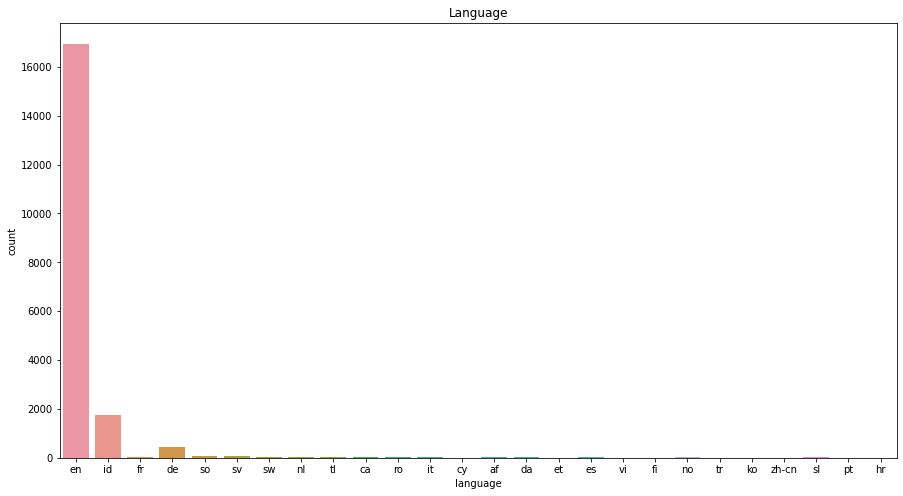

In [70]:
plt.figure(figsize=(15,8))
sns.countplot(x='language', data=df).set_title('Language');

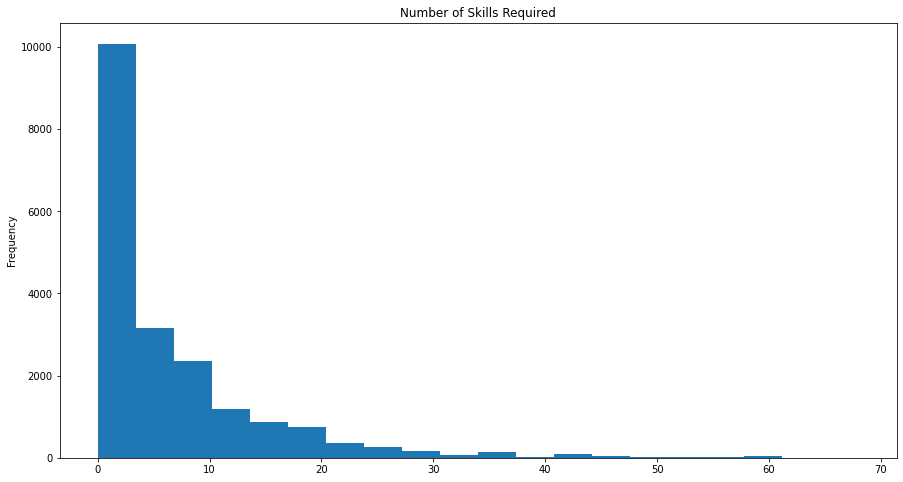

In [71]:
plt.figure(figsize=(15,8))
df['no_skills_required'].plot.hist(bins=20, title='Number of Skills Required');

## Data Percentages

### Language
#### English

In [74]:
len(df.loc[df['language'] == 'en']) * 100 / len(df)

86.1280487804878

### Skills

#### No skills

In [76]:
len(df.loc[df['no_skills_required'] == 0]) * 100 / len(df)

17.891260162601625

#### More than 10 skills

In [77]:
len(df.loc[df['no_skills_required'] > 10]) * 100 / len(df)

20.670731707317074